In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pymc as pm
import warnings

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8')

# Load price data (processed with log returns)
df = pd.read_csv("BrentOilPrices.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y', errors='coerce')
df = df.dropna().sort_values('Date').reset_index(drop=True)
df['Log_Returns'] = np.log(df['Price'] / df['Price'].shift(1))
df.dropna(inplace=True)

# Load events dataset
events_df = pd.read_csv("events_dataset.csv")
events_df['Date'] = pd.to_datetime(events_df['Date'])


In [5]:
change_point_index = 8357
mu_1_mean = -0.00000
mu_2_mean = -0.52500


In [6]:
change_date = df.iloc[change_point_index]['Date']
print(f"Most probable change point detected at index {change_point_index}, which corresponds to date: {change_date.date()}")


Most probable change point detected at index 8357, which corresponds to date: 2020-04-20


In [7]:
# Find the event closest to the change date
events_df['Days_From_CP'] = (events_df['Date'] - change_date).abs().dt.days
closest_event = events_df.loc[events_df['Days_From_CP'].idxmin()]

print("Closest Event to Change Point:")
print(closest_event[['Date', 'Event_Type', 'Event_Description', 'Expected_Impact']])


Closest Event to Change Point:
Date                                               2020-04-12 00:00:00
Event_Type                                             OPEC+ Agreement
Event_Description    OPEC+ agrees to cut production by 9.7 million bpd
Expected_Impact                Supply reduction to counter demand drop
Name: 15, dtype: object


In [16]:
delta = mu_2_mean - mu_1_mean

# Only compute percent_change if mu_1_mean is not too close to zero
if abs(mu_1_mean) > 1e-6:
    percent_change = (delta / abs(mu_1_mean)) * 100
    percent_change_str = f"{percent_change:.2f}% change"
else:
    percent_change = np.nan # Assign NaN when percentage change is not reliably computed
    percent_change_str = "undefined (mu_1_mean ≈ 0)"

print(f"\nChange in mean log returns:")
print(f"Before change point: {mu_1_mean:.5f}")
print(f"After change point: {mu_2_mean:.5f}")
print(f"Δ Mean: {delta:.5f} ({percent_change_str})")


Change in mean log returns:
Before change point: -0.00000
After change point: -0.52500
Δ Mean: -0.52500 (undefined (mu_1_mean ≈ 0))


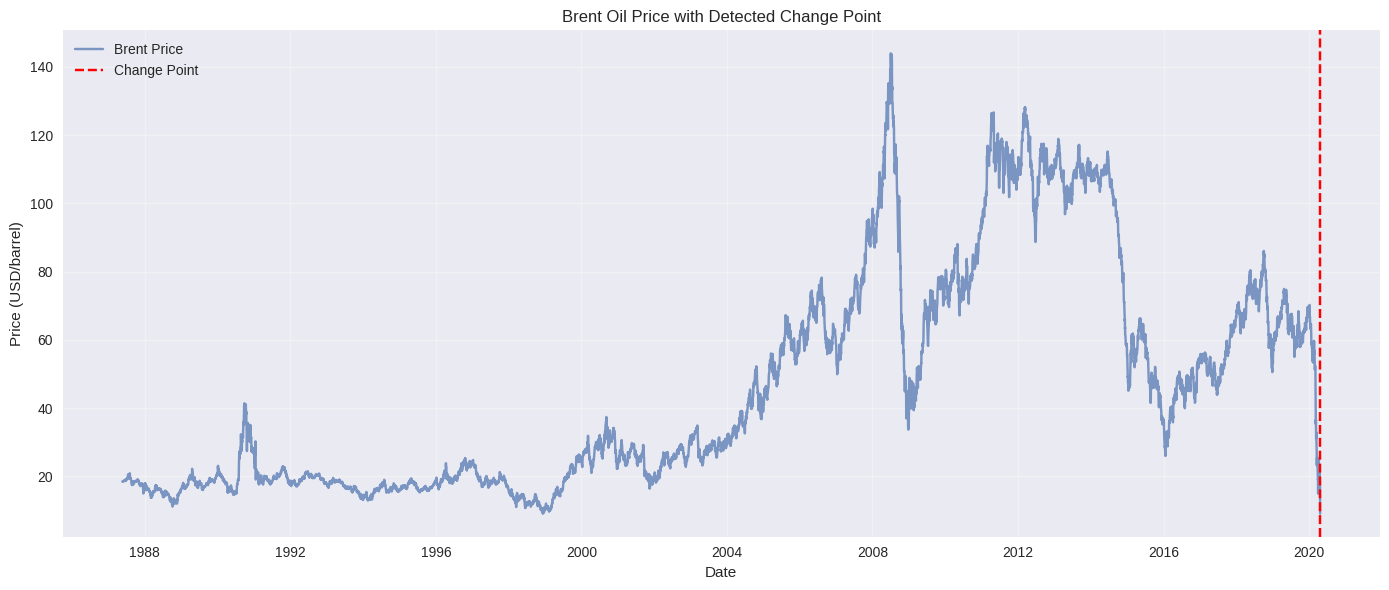

In [13]:
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Price'], label='Brent Price', alpha=0.7)
plt.axvline(x=change_date, color='red', linestyle='--', label='Change Point')
plt.title('Brent Oil Price with Detected Change Point')
plt.xlabel('Date')
plt.ylabel('Price (USD/barrel)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


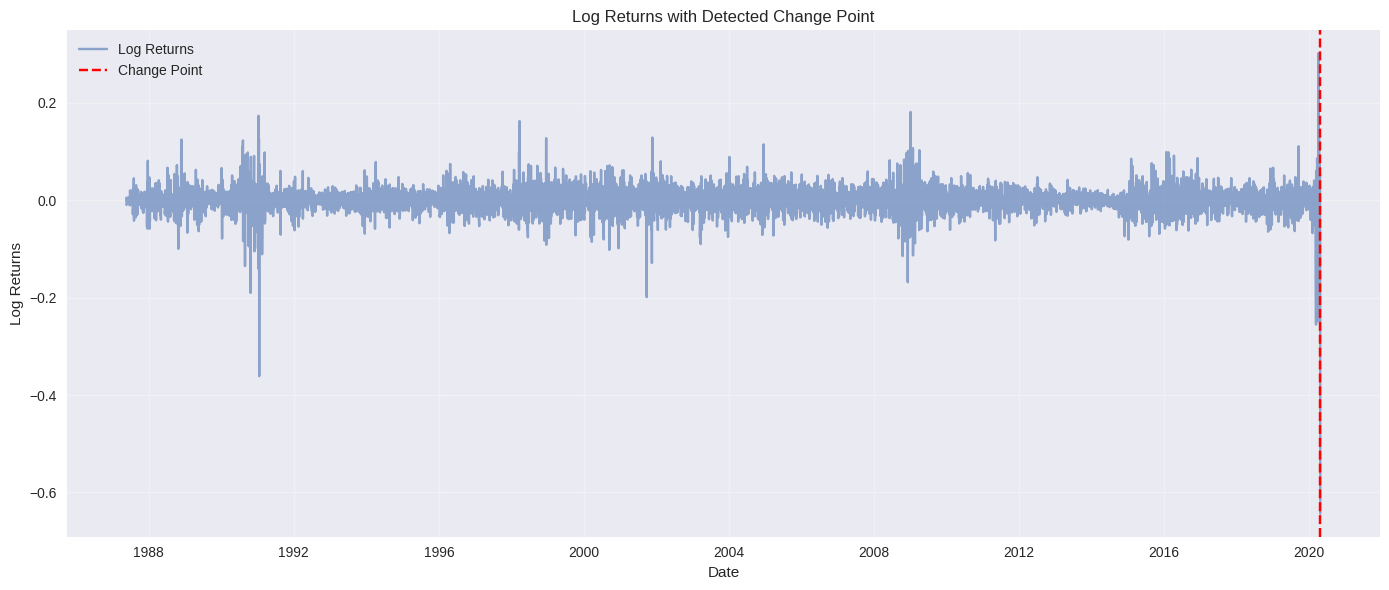

In [14]:
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Log_Returns'], label='Log Returns', alpha=0.6)
plt.axvline(x=change_date, color='red', linestyle='--', label='Change Point')
plt.title('Log Returns with Detected Change Point')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [18]:
summary_df = pd.DataFrame({
    "Change Point Date": [change_date.date()],
    "Closest Event Date": [closest_event['Date'].date()],
    "Event": [closest_event['Event_Description']],
    "Impact": [closest_event['Expected_Impact']],
    "Mean Before": [mu_1_mean],
    "Mean After": [mu_2_mean],
    "Δ Mean": [delta],
    "% Change": [percent_change_str] # Use the string representation here
})

display(summary_df)

,Change Point Date,Closest Event Date,Event,Impact,Mean Before,Mean After,Δ Mean,% Change
0,2020-04-20,2020-04-12,OPEC+ agrees to cut production by 9.7 million bpd,Supply reduction to counter demand drop,-0.0,-0.525,-0.525,undefined (mu_1_mean ≈ 0)
